# Semantic chunk score exploration

Now that we have some of the semantic chunk data scored for perplexity ratio, let's take a look and see what we are working with.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would from the perplexity ratio score root directory
%cd ..

# PyPI imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statistics import mean
from scipy.stats import ttest_ind

# Internal imports
import configuration as config
import notebooks.helper_functions.plotting_functions as plot_funcs

/home/siderealyear/projects/llm_detector/perplexity_ratio_score


## 1. Data loading

In [2]:
data_file=f'{config.SCORED_DATA_PATH}/test_chunks.19.parquet'
data_df=pd.read_parquet(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6888 entries, 0 to 6887
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   text                    6888 non-null   object 
 1   synthetic               6888 non-null   int64  
 2   author                  6888 non-null   object 
 3   source                  6888 non-null   object 
 4   perplexity_ratio_score  6799 non-null   float32
dtypes: float32(1), int64(1), object(3)
memory usage: 242.3+ KB


In [3]:
data_df.head()

,text,synthetic,author,source,perplexity_ratio_score
0,"Lastly, online classes can help us learn in a ...",1,unknown_model,gerami,0.600559
1,"Therefore, one should not work to be like othe...",0,human,yatsenko,0.705907
2,", their overall safety record remains to be pr...",1,unknown_model,grinberg,0.850475
3,Need to be mentioned that the U.S.-led forces ...,0,human,yatsenko,1.045055
4,The spike in temperatures that we would be exp...,1,unknown_model,yatsenko,1.119257


## 2. Data composition

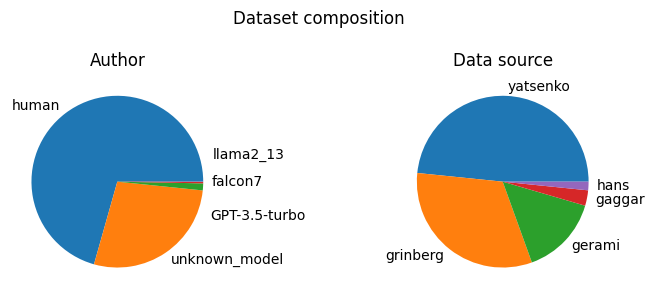

In [4]:
plot_obj=plot_funcs.data_composition(data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/07-2_data_composition.jpg')
plot_obj.show()

## 3. Text length

In [5]:
data_df['words']=data_df['text'].apply(lambda x: len(x.split(' ')))
data_df['words'].describe()

count    6888.000000
mean       28.647213
std        54.967486
min         1.000000
25%        10.000000
50%        15.000000
75%        27.000000
max      2576.000000
Name: words, dtype: float64

### 3.1. Length distributions: all text

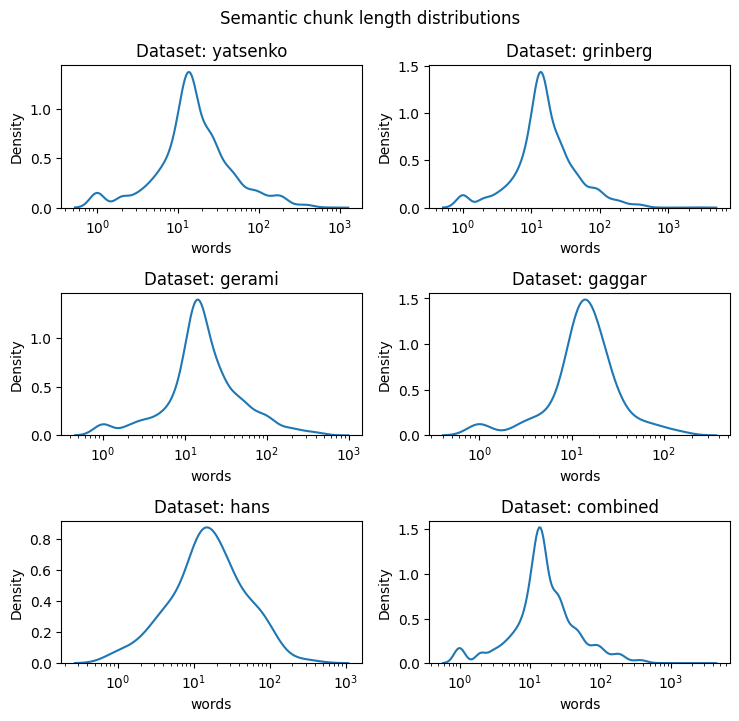

In [6]:
plot_obj=plot_funcs.length_distributions('Semantic chunk length distributions', data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/07-3.1_semantic_chunk_length_distributions.jpg')
plot_obj.show()

Just for fun, let's take a look at the chunk length distributions for human vs machine text. But before we do - let's provisionally get rid of any single word chunks - we can pretty clearly justify that as a splitting failure, if nothing else. Let's also trim off very long chunks.

### 3.2. Length distributions: human vs synthetic

In [7]:
# Length threshold the data
working_data_df=data_df[data_df['words'] > 1]
working_data_df=working_data_df[working_data_df['words'] < 1024]

# Replace int values for 'synthetic' with human readable strings
working_data_df['synthetic']=working_data_df['synthetic'].map({0: 'human', 1: 'synthetic'})
working_data_df.head()

,text,synthetic,author,source,perplexity_ratio_score,words
0,"Lastly, online classes can help us learn in a ...",synthetic,unknown_model,gerami,0.600559,12
1,"Therefore, one should not work to be like othe...",human,human,yatsenko,0.705907,10
2,", their overall safety record remains to be pr...",synthetic,unknown_model,grinberg,0.850475,15
3,Need to be mentioned that the U.S.-led forces ...,human,human,yatsenko,1.045055,33
4,The spike in temperatures that we would be exp...,synthetic,unknown_model,yatsenko,1.119257,16


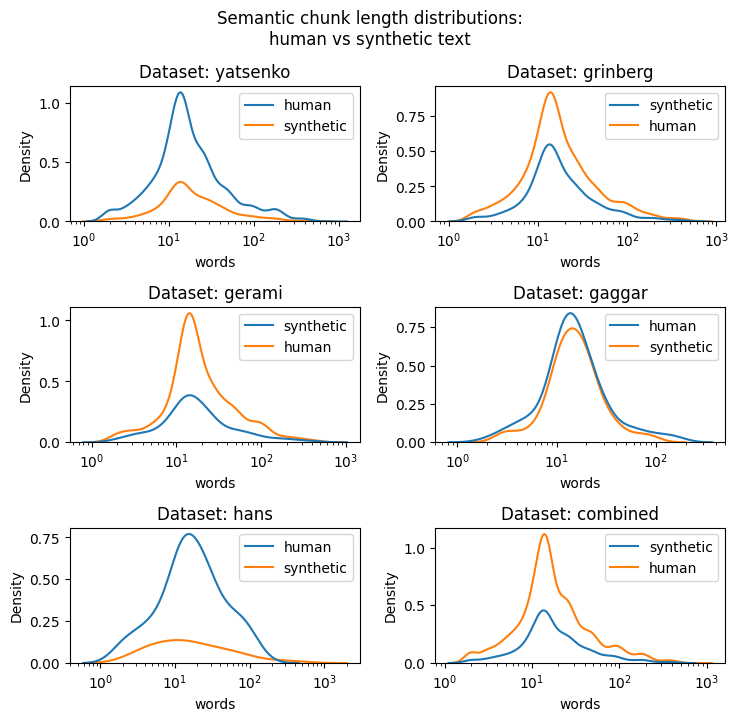

In [8]:
plot_obj=plot_funcs.length_distributions(
    'Semantic chunk length distributions:\nhuman vs synthetic text',
    working_data_df, 
    hue_by='synthetic'
)

plot_obj.savefig(f'{config.PLOT_PATH}/07-3.2_human_vs_synthetic_length_distributions.jpg')
plot_obj.show()

Both distributions plots look qualitatively similar to those generated from the complete dataset prior to scoring. Let's move on and look a the perplexity ratio score.

## 4. Perplexity ratio score

### 4.1. Human vs synthetic mean by dataset source

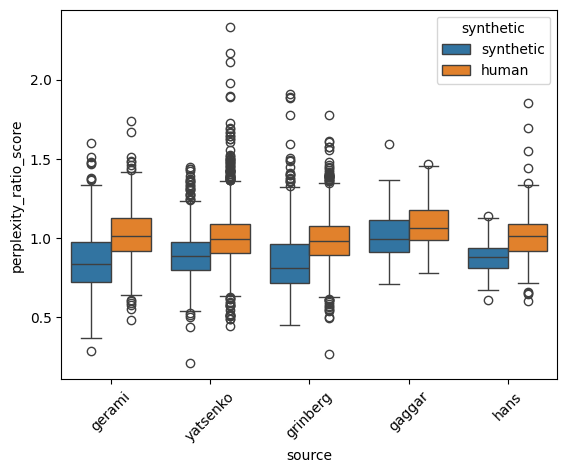

In [9]:
ax=sns.boxplot(data=working_data_df, x='source', y='perplexity_ratio_score', hue='synthetic')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(f'{config.PLOT_PATH}/07-4.1_perplexity_ratio_score_mean_by_dataset_source.jpg')
plt.show()

OK - cool! Looks qualitatively similar to the original Hans dataset by itself. Means are pretty clearly different, but there is a lot of overlap between the distributions. 

It's interesting that the Gaggar dataset seems the least differentiated and scores highest overall. That dataset contains GPT-3.5-turbo output, which is the most powerful adversary model in the dataset. But, the data was also created by prompting the model to rephrase human written text. This is different than purely generated responses.

Let's do a t-test and set-up a confidence interval around the difference in means to find out a little more quantitatively how different the two distributions actually are.

### 4.2. Human vs synthetic mean by author

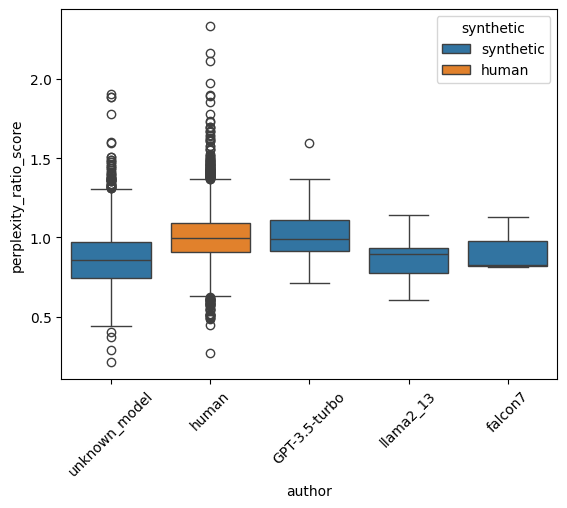

In [10]:
ax=sns.boxplot(data=working_data_df, x='author', y='perplexity_ratio_score', hue='synthetic')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(f'{config.PLOT_PATH}/07-4.2_perplexity_ratio_score_mean_by_author.jpg')
plt.show()

Same observations as above apply. Perplexity score mean is lower for synthetic text on average. The only model the output of which we are not convincingly detecting in aggregate is GPT-3.5-turbo, but again this is a 'rephrasing' dataset, not a de novo machine generated text dataset.

The only real solution to that kind of nit-picking is to synthesize our own data using a selection of different models. Problem will be the cost of using proprietary APIs to do so. No one is gonna take us seriously if we can't detect the newest, fanciest chatGPT.

For now, we can just exclude the gagger data on the basis of how it was generated if it drags the dataset wide accuracy down too much.

In [11]:
# Split the data into human and synthetic
human_df=working_data_df[working_data_df['synthetic'] == 'human']
synthetic_df=working_data_df[working_data_df['synthetic'] == 'synthetic']

# Pull the data for this model
human=human_df['perplexity_ratio_score']
synthetic=synthetic_df['perplexity_ratio_score']

# Get the means in question and their difference
human_mean=mean(human)
synthetic_mean=mean(synthetic)
mean_diff=human_mean - synthetic_mean

# Get the confidence interval
cm=sms.CompareMeans(sms.DescrStatsW(human), sms.DescrStatsW(synthetic))
difference=cm.tconfint_diff(usevar='unequal')
low_bound=difference[0]
high_bound=difference[1]

# Do a t-test with H0 equal means, H1 human greater than synthetic
ttest_result = ttest_ind(human, synthetic, alternative='greater')

print(f'T-test p-value = {ttest_result.pvalue}')
print(f'Difference in means = {mean_diff:.3f}, 95% CI = ({low_bound:.3f}, {high_bound:.3f})')

T-test p-value = 5.4007199658014885e-152
Difference in means = 0.124, 95% CI = (0.115, 0.134)


Good, marginally better even. Just for reference - here is the Falcon-7B reader/writer result for the old Hans only dataset:

```
Model: Falcon-7B, t-test p-value = 1.468072030319169e-94
Model: Falcon-7B, difference in means = 0.116, 95% CI = (0.106, 0.126)
```

### 4.3. Human vs synthetic distribution

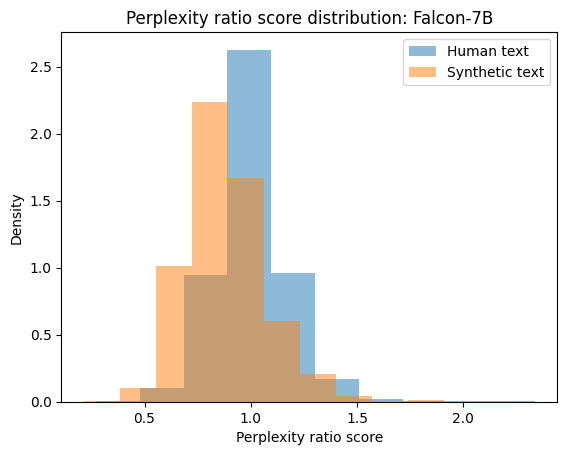

In [12]:
plt.title('Perplexity ratio score distribution: Falcon-7B')
plt.hist(human_df['perplexity_ratio_score'], density=True, label='Human text', alpha=0.5)
plt.hist(synthetic_df['perplexity_ratio_score'], density=True, label='Synthetic text', alpha=0.5)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-4.3_perplexity_ratio_score_distribution.jpg')
plt.show()

### 4.4. Perplexity ratio score by text length

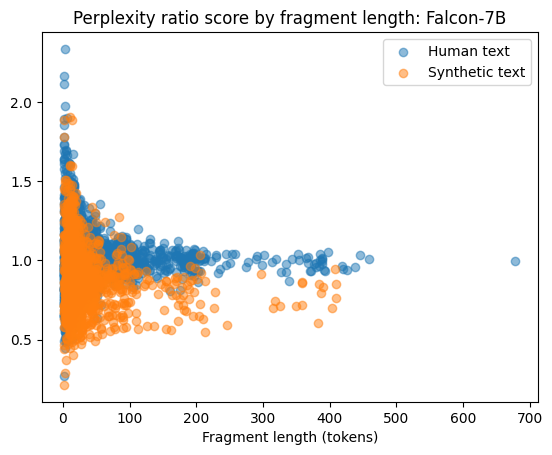

In [13]:
plt.title('Perplexity ratio score by fragment length: Falcon-7B')
plt.scatter(human_df['words'], human_df['perplexity_ratio_score'], alpha=0.5, label='Human text')
plt.scatter(synthetic_df['words'], synthetic_df['perplexity_ratio_score'], alpha=0.5, label='Synthetic text')
plt.xlabel('Fragment length (tokens)')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-4.4_perplexity_ratio_score_by_text_length.jpg')
plt.show()

Also, on the whole, very similar to the Hans data alone. Even if the fact that the gagger synthetic GPT data seems to score similarly to human is slightly concerning, it's good news that overall our trick seems to work well on data from other sources.